In [1]:
import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import scipy.io

import scipy.sparse as sps
import matplotlib.pyplot as plt

from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

from scNCL.metrics import osr_evaluator
from scNCL.core import BuildscNCL
import scNCL.utils as utls

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(1234)

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.8 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.11.1 python-igraph==0.9.4 louvain==0.7.0


## experiment id

In [3]:
exp_id = 'PBMC' + '-demo'  # dataset_name + timestamp

## loading data

In [4]:
data_root = './demo_data'

# github only allows to upload single file smaller than 100 MB :(
# so, I split each count_data into two files
count_gem1 = sps.load_npz(join(data_root, 'rna_gem1.npz'))
count_gem2 = sps.load_npz(join(data_root, 'rna_gem2.npz'))
count_gam1 = sps.load_npz(join(data_root, 'atac_gam1.npz'))  
count_gam2 = sps.load_npz(join(data_root, 'atac_gam2.npz')) 
meta = pd.read_csv(join(data_root, 'meta.csv'), index_col=0)
gene_names = pd.read_csv(join(data_root, 'gene_names.csv'), header=None, index_col=0)

# concat them
count_gem = sps.vstack([count_gem1, count_gem2])
count_gam = sps.vstack([count_gam1, count_gam2])

# set AnnData
adata_rna = sc.AnnData(count_gem, obs=meta, var=gene_names)
adata_atac = sc.AnnData(count_gam, obs=meta, var=gene_names)
adata_rna.obs['domain'] = 'rna'
adata_atac.obs['domain'] = 'atac'

meta_rna = adata_rna.obs.copy()
meta_atac = adata_atac.obs.copy()

In [5]:
# low-dimension representations of raw scATAC-seq data
atac_raw_emb = np.load(join(data_root, 'pbmc_atac_lsi.npy'))
atac_raw_emb.shape

(10412, 29)

In [6]:
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':8000,  # for speed
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':False
       }  # default settings

#  outputs folder
output_dir = join(f'../outputs/{exp_id}')
os.makedirs(output_dir, exist_ok=True)

## model 

In [7]:
model = BuildscNCL(
                n_latent=64, bn=False, dr=0.2, 
                cont_w=0.06, cont_tau=0.1,
                align_w=0.05, align_p=0.8, align_cutoff=100,
        )
    
model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=None, 
                pp_dict = ppd
        )
    
if 1:
    model.train(
        batch_size=512, training_steps=3000, 
        lr=0.01, weight_decay=0,
        log_step=200, eval_atac=False, #eval_top_k=1, eval_open=True,  
    )
else:
    # loading checkpoints
    ckpt_path = join(output_dir, 'ckpt_3000.pth')
    model.load_ckpt(ckpt_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


knn correct ratio = 0.8937
step 0, loss_cls=2.930, loss_l1_reg=0.013, center=(0.015, 0.028), corr=(0.000, 0.000), var=(0.799, 0.525), loss_cont=0.413, loss_align=0.050
step 200, loss_cls=0.342, loss_l1_reg=0.013, center=(0.066, 0.073), corr=(0.012, 0.015), var=(0.154, 0.137), loss_cont=0.305, loss_align=0.006
step 400, loss_cls=0.155, loss_l1_reg=0.015, center=(0.064, 0.075), corr=(0.010, 0.013), var=(0.155, 0.132), loss_cont=0.293, loss_align=0.005
step 600, loss_cls=0.089, loss_l1_reg=0.016, center=(0.062, 0.076), corr=(0.009, 0.013), var=(0.162, 0.131), loss_cont=0.294, loss_align=0.005
step 800, loss_cls=0.063, loss_l1_reg=0.016, center=(0.060, 0.076), corr=(0.008, 0.012), var=(0.165, 0.129), loss_cont=0.282, loss_align=0.006
step 1000, loss_cls=0.040, loss_l1_reg=0.017, center=(0.059, 0.077), corr=(0.007, 0.012), var=(0.168, 0.129), loss_cont=0.281, loss_align=0.006
step 1200, loss_cls=0.034, loss_l1_reg=0.018, center=(0.058, 0.077), corr=(0.007, 0.012), var=(0.171, 0.128), loss_c

In [8]:
model.eval(inplace=True)
atac_pred_type = model.annotate()

In [9]:
ad_atac = sc.AnnData(model.feat_B, obs=meta_atac)

ad_atac.obs['pred_type'] = atac_pred_type
ad_atac.obs['pred_conf'] = np.max(model.head_B, axis=1)

In [11]:
ad_atac = utls.umap_for_adata(ad_atac)

... storing 'orig.ident' as categorical
... storing 'seurat_annotations' as categorical
... storing 'domain' as categorical
... storing 'cell_type' as categorical
... storing 'pred_type' as categorical


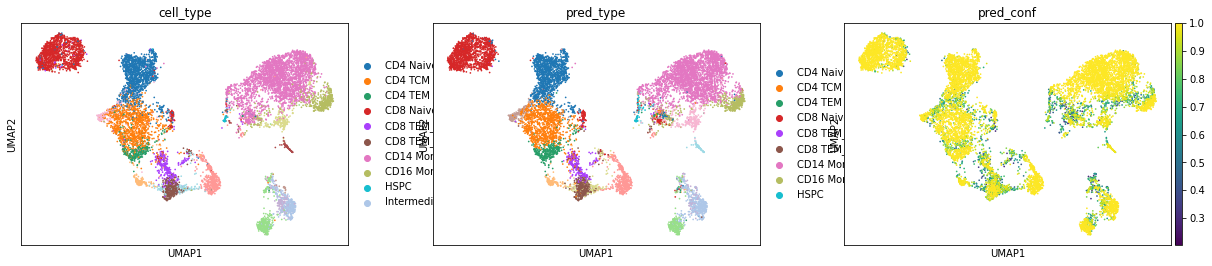

In [12]:
sc.pl.umap(ad_atac, color=['cell_type', 'pred_type', 'pred_conf'])

# Evaluation

In [14]:
share_mask = meta_atac.cell_type.isin(meta_rna.cell_type.unique()).to_numpy()
open_score = 1 - np.max(model.head_B, axis=1) 

kn_data_pr = atac_pred_type[share_mask]
kn_data_gt = meta_atac.cell_type[share_mask].to_numpy()
kn_data_open_score = open_score[share_mask]
unk_data_open_score = open_score[np.logical_not(share_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)

close_acc= 0.8706


<AxesSubplot:>

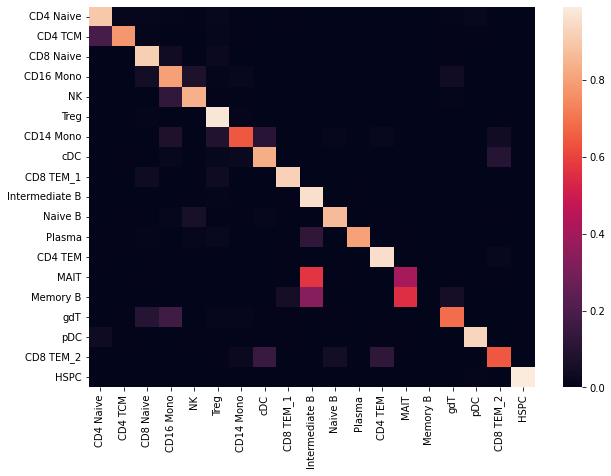

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(meta_atac.cell_type.to_numpy(), atac_pred_type)
cm = cm/cm.sum(axis=1, keepdims=True)

df_cm = pd.DataFrame(cm, index = meta_atac.cell_type.unique(),
                  columns = meta_atac.cell_type.unique())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, )